In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import os

# Set your project directory in Google Drive
project_dir = '/content/drive/MyDrive/Resume_Screening_Project'
if not os.path.exists(project_dir):
    os.makedirs(project_dir)

# Change working directory to the project directory
os.chdir(project_dir)

In [ ]:
# Import necessary libraries
import os
# Import necessary libraries
import pandas as pd
# Import necessary libraries
import re

# Set the project directory
project_dir = '/content/drive/MyDrive/Resume_Screening_Project'
os.chdir(project_dir)

def load_resume_data(filepath):
    """Load and perform initial checks on resume data"""
# Load the dataset using Pandas
    df = pd.read_csv(filepath)
    print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

def clean_text(text):
    """Clean and normalize resume text"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_education_degrees(df, degree_col='education_degree'):
    df_clean = df.copy()
    degree_patterns = {
        r'\b(B\.?Tech|Bachelor\s?of\s?Technology)': 'B.Tech',
        r'\b(B\.?E\.?|Bachelor\s?of\s?Engineering)': 'B.E.',
        r'\b(BCA|Bachelor\s?of\s?Computer\s?Applications)': 'BCA',
        r'\b(B\.?Sc|Bachelor\s?of\s?Science)': 'B.Sc',
        r'\b(M\.?Tech|Master\s?of\s?Technology)': 'M.Tech',
        r'\b(M\.?E\.?|Master\s?of\s?Engineering)': 'M.E.',
        r'\b(MCA|Master\s?of\s?Computer\s?Applications)': 'MCA',
        r'\b(MBA|Master\s?of\s?Business\s?Administration)': 'MBA',
        r'\b(Ph\.?D\.?|Doctor\s?of\s?Philosophy)': 'Ph.D.',
        r'\b(Diploma)': 'Diploma'
    }

    def normalize_degree(degree_str):
        if pd.isna(degree_str) or not isinstance(degree_str, str):
            return "Unknown"

        base_degree = re.sub(r'\s+in\s+.*', '', degree_str)
        for pattern, standard_name in degree_patterns.items():
            if re.search(pattern, base_degree, re.IGNORECASE):
                return standard_name

        if any(word in degree_str.lower() for word in ['certificate', 'certification']):
            return "Certification"

        return "Other"

    df_clean['normalized_education_degree'] = df_clean[degree_col].apply(normalize_degree)
    return df_clean

def save_processed_data(df, filepath):
    df.to_csv(filepath, index=False)
    print(f"Processed data saved to {filepath}")

# Example usage:
data_filepath = 'enhanced_synthetic_indian_tech_resumes.csv'
processed_filepath = 'processed_resumes.csv'

df = load_resume_data(data_filepath)
df['cleaned_resume'] = df['Resume'].apply(clean_text)
df = normalize_education_degrees(df)
save_processed_data(df, processed_filepath)

Loaded dataset with 10000 rows and 18 columns
Processed data saved to processed_resumes.csv


In [ ]:
# Import necessary libraries
import pandas as pd

# Load processed data
processed_filepath = 'processed_resumes.csv'
# Load the dataset using Pandas
df = pd.read_csv(processed_filepath)

# Display the first few rows
print(df.head())

     candidate_id              name              location  \
0  IND-TECH-00001   Siddharth Patil  Hyderabad, Telangana   
1  IND-TECH-00002    Aadhavan Dutta  Mangalore, Karnataka   
2  IND-TECH-00003   Divya Deshpande  Mangalore, Karnataka   
3  IND-TECH-00004    Nitya Malhotra     Jaipur, Rajasthan   
4  IND-TECH-00005  Nitya Chatterjee      Gurgaon, Haryana   

                  Category                                             Resume  \
0  Database Administration  \nSiddharth Patil\nHyderabad, Telangana | +91 ...   
1   Full Stack Development  \nAadhavan Dutta\nMangalore, Karnataka | +91 9...   
2   Full Stack Development  \nDivya Deshpande\nMangalore, Karnataka | +91 ...   
3            Cybersecurity  \nNitya Malhotra\nJaipur, Rajasthan | +91 8648...   
4     Software Development  \nNitya Chatterjee\nGurgaon, Haryana | +91 829...   

                                              skills  experience_years  \
0  ["English Proficiency", "Replication", "MySQL"...                 0  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Scale the features for better model performance
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Import necessary libraries
import numpy as np

# Combine text features
df['combined_text'] = df['cleaned_resume'] + " " + df['skills'] + " " + df['keywords']

# Encode categorical features
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

# Normalize numerical features
# Scale the features for better model performance
scaler = StandardScaler()
df['experience_years_scaled'] = scaler.fit_transform(df[['experience_years']])
df['match_score_scaled'] = scaler.fit_transform(df[['match_score']])

# TF-IDF for text features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = tfidf.fit_transform(df['combined_text'])

# Combine all features
numerical_features = df[['experience_years_scaled', 'match_score_scaled']].values
categorical_features = df['Category_encoded'].values.reshape(-1, 1)
all_features = np.hstack((tfidf_features.toarray(), numerical_features, categorical_features))

# Target variable
y = df['Category_encoded']

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Reduce TF-IDF features to 100 dimensions
svd = TruncatedSVD(n_components=100)
reduced_tfidf_features = svd.fit_transform(tfidf_features)

# Combine reduced features with numerical and categorical features
all_features_reduced = np.hstack((reduced_tfidf_features, numerical_features, categorical_features))

In [ ]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features_reduced, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
# Evaluate the model performance
from sklearn.metrics import classification_report, f1_score

# Train Logistic Regression model
model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42)
# Train the machine learning model
model.fit(X_train, y_train)

# Evaluate on test set
# Make predictions using the trained model
y_pred = model.predict(X_test)
# Evaluate the model performance
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

                              precision    recall  f1-score   support

         Backend Development       1.00      1.00      1.00        95
       Business Intelligence       1.00      1.00      1.00        91
          Cloud Architecture       1.00      1.00      1.00        95
               Cybersecurity       1.00      1.00      1.00        94
            Data Engineering       1.00      1.00      1.00        96
                Data Science       1.00      1.00      1.00        95
     Database Administration       1.00      1.00      1.00        86
          DevOps Engineering       1.00      1.00      1.00        95
          ERP/SAP Consultant       1.00      1.00      1.00        64
            Embedded Systems       1.00      1.00      1.00        64
        Frontend Development       1.00      1.00      1.00        95
      Full Stack Development       1.00      1.00      1.00        95
       IT Project Management       1.00      1.00      1.00        90
             IoT De

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.linear_model import LogisticRegression
# Scale the features for better model performance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
# Evaluate the model performance
from sklearn.metrics import classification_report, f1_score

# Scale all features
# Scale the features for better model performance
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce dimensionality
svd = TruncatedSVD(n_components=100)
X_train_reduced = svd.fit_transform(X_train_scaled)
X_test_reduced = svd.transform(X_test_scaled)

# Train Logistic Regression model
model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42)
# Train the machine learning model
model.fit(X_train_reduced, y_train)

# Evaluate on test set
# Make predictions using the trained model
y_pred = model.predict(X_test_reduced)
# Evaluate the model performance
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

                              precision    recall  f1-score   support

         Backend Development       1.00      1.00      1.00        95
       Business Intelligence       1.00      1.00      1.00        91
          Cloud Architecture       1.00      1.00      1.00        95
               Cybersecurity       1.00      1.00      1.00        94
            Data Engineering       1.00      1.00      1.00        96
                Data Science       1.00      1.00      1.00        95
     Database Administration       1.00      1.00      1.00        86
          DevOps Engineering       1.00      1.00      1.00        95
          ERP/SAP Consultant       1.00      1.00      1.00        64
            Embedded Systems       1.00      1.00      1.00        64
        Frontend Development       1.00      1.00      1.00        95
      Full Stack Development       1.00      1.00      1.00        95
       IT Project Management       1.00      1.00      1.00        90
             IoT De

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2']
}

# Grid search
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=skf, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
# Make predictions using the trained model
y_pred = best_model.predict(X_test)
# Evaluate the model performance
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best F1 Score: 1.0
                              precision    recall  f1-score   support

         Backend Development       1.00      1.00      1.00        95
       Business Intelligence       1.00      1.00      1.00        91
          Cloud Architecture       1.00      1.00      1.00        95
               Cybersecurity       1.00      1.00      1.00        94
            Data Engineering       1.00      1.00      1.00        96
                Data Science       1.00      1.00      1.00        95
     Database Administration       1.00      1.00      1.00        86
          DevOps Engineering       1.00      1.00      1.00        95
          ERP/SAP Consultant       1.00      1.00      1.00        64
            Embedded Systems       1.00      1.00      1.00        64
        Frontend Development       1.00      1.00      1.00        95
      Full Stack Development       1.00      1.00      1.00        95
       IT Project Manage

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loaded 10000 processed resumes

Analyzing job categories...
Found 23 different job categories


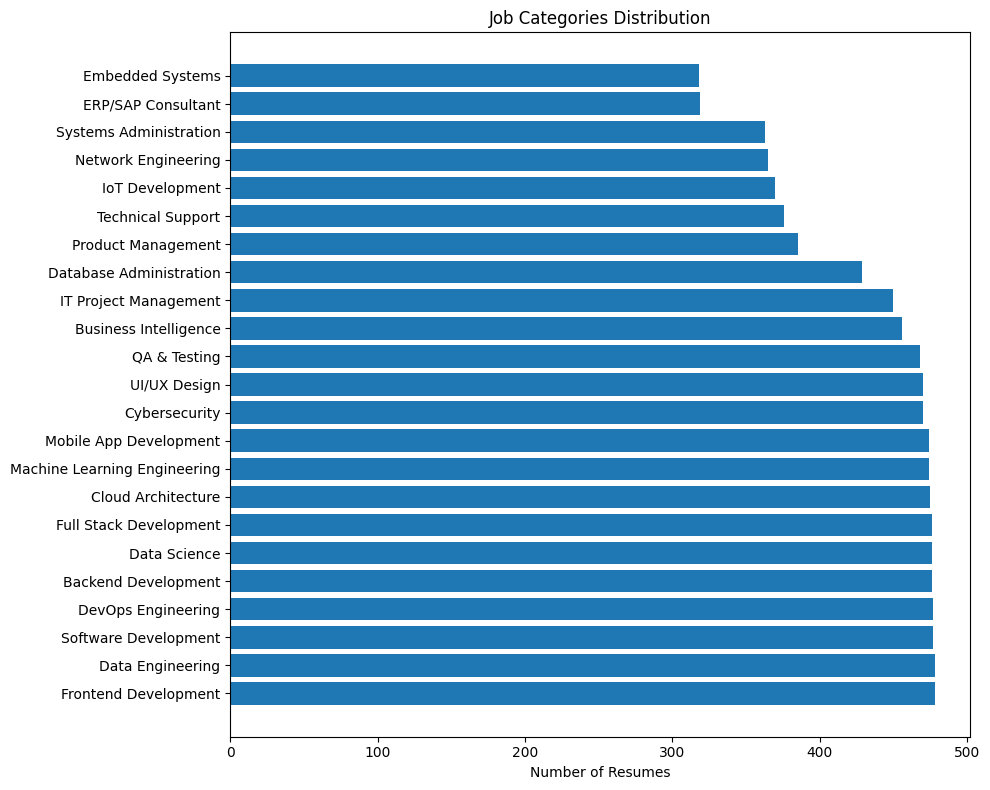


Analyzing experience distribution...
Experience range: 0 to 20 years
Average experience: 6.3 years


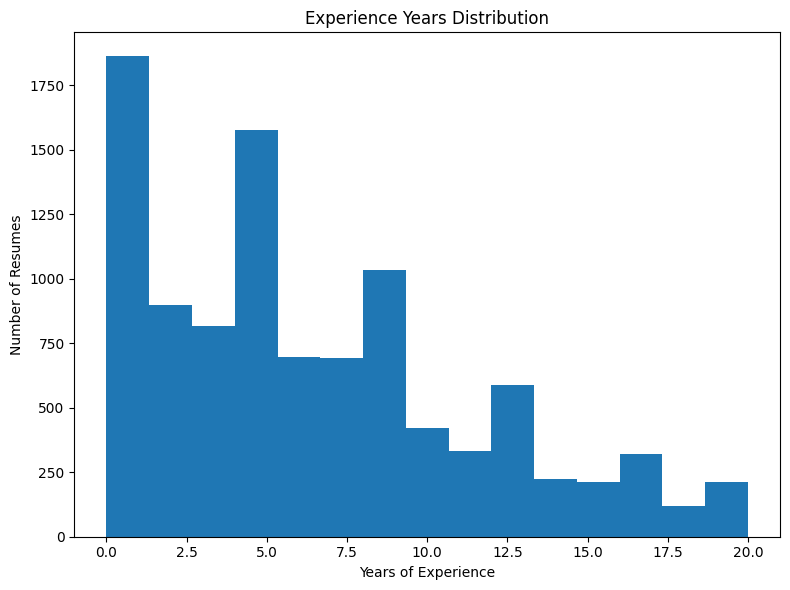


Analyzing education distribution...
Most common degree: B.Sc (1639 resumes)


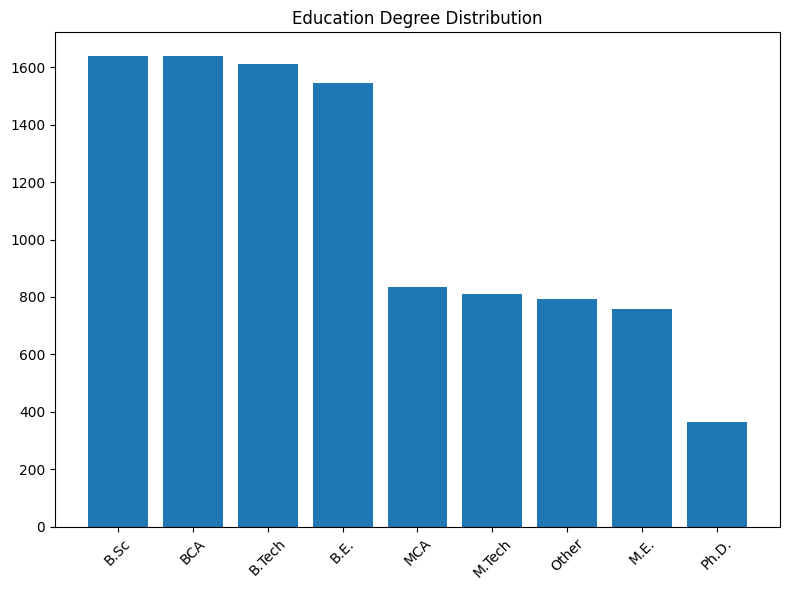

In [ ]:
# Import necessary libraries
import os
# Import necessary libraries
import pandas as pd
# Import necessary libraries
import matplotlib.pyplot as plt

# Load the processed data
# Load the dataset using Pandas
df = pd.read_csv('processed_resumes.csv')
print(f"Loaded {len(df)} processed resumes")

# Create a directory for visualizations
visualizations_dir = 'visualizations'
if not os.path.exists(visualizations_dir):
    os.makedirs(visualizations_dir)

# 1. Category distribution
print("\nAnalyzing job categories...")
plt.figure(figsize=(10, 8))
category_counts = df['Category'].value_counts()
plt.barh(category_counts.index, category_counts.values)
plt.title('Job Categories Distribution')
plt.xlabel('Number of Resumes')
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'categories.png'))
print(f"Found {len(category_counts)} different job categories")
plt.show()

# 2. Experience distribution
print("\nAnalyzing experience distribution...")
plt.figure(figsize=(8, 6))
plt.hist(df['experience_years'], bins=15)
plt.title('Experience Years Distribution')
plt.xlabel('Years of Experience')
plt.ylabel('Number of Resumes')
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'experience.png'))
print(f"Experience range: {df['experience_years'].min()} to {df['experience_years'].max()} years")
print(f"Average experience: {df['experience_years'].mean():.1f} years")
plt.show()

# 3. Education distribution
print("\nAnalyzing education distribution...")
plt.figure(figsize=(8, 6))
degree_counts = df['normalized_education_degree'].value_counts()
plt.bar(degree_counts.index, degree_counts.values)
plt.title('Education Degree Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir, 'education.png'))
print(f"Most common degree: {degree_counts.index[0]} ({degree_counts.values[0]} resumes)")
plt.show()

In [ ]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = "processed_resumes.csv"  # Update this if needed
# Load the dataset using Pandas
df = pd.read_csv(file_path)

# Display basic information
print("🔹 Dataset Overview")
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
print("\nColumn Names:", df.columns.tolist())

# Check for missing values
print("\n🔹 Missing Values")
print(df.isnull().sum())

# Show data types
print("\n🔹 Data Types")
print(df.dtypes)

# Show first few rows
print("\n🔹 Sample Data")
print(df.head())

# Unique categories in 'Category' column (Job Roles)
if "Category" in df.columns:
    print("\n🔹 Job Role Distribution")
    print(df["Category"].value_counts())

# Resume text length statistics
if "cleaned_resume" in df.columns:
    df["resume_length"] = df["cleaned_resume"].apply(lambda x: len(str(x).split()))
    print("\n🔹 Resume Length Stats (Word Count)")
    print(df["resume_length"].describe())

# Unique values in education degrees (if applicable)
if "normalized_education_degree" in df.columns:
    print("\n🔹 Unique Education Degrees")
    print(df["normalized_education_degree"].value_counts())


🔹 Dataset Overview
Total Rows: 10000
Total Columns: 20

Column Names: ['candidate_id', 'name', 'location', 'Category', 'Resume', 'skills', 'experience_years', 'job_titles', 'companies', 'education_degree', 'education_institution', 'match_score', 'domain', 'keywords', 'certifications', 'languages_spoken', 'languages_programming', 'is_synthetic', 'cleaned_resume', 'normalized_education_degree']

🔹 Missing Values
candidate_id                   0
name                           0
location                       0
Category                       0
Resume                         0
skills                         0
experience_years               0
job_titles                     0
companies                      0
education_degree               0
education_institution          0
match_score                    0
domain                         0
keywords                       0
certifications                 0
languages_spoken               0
languages_programming          0
is_synthetic             

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
# Import necessary libraries
import pickle
# Import necessary libraries
import os

# Load processed data
print("Loading processed data...")
# Load the dataset using Pandas
df = pd.read_csv('processed_resumes.csv')

# Split data into training and testing sets
print("Splitting data into train and test sets...")
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_resume'],
    df['Category'],
    test_size=0.2,
    random_state=42
)

print(f"Training set: {len(X_train)} resumes")
print(f"Testing set: {len(X_test)} resumes")

# Create TF-IDF features
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

# Save our features and labels
print("Saving features and labels...")

# Create directories for features if they don't exist
features_dir = 'features'
if not os.path.exists(features_dir):
    os.makedirs(features_dir)

with open(os.path.join(features_dir, 'X_train_tfidf.pkl'), 'wb') as f:
    pickle.dump(X_train_tfidf, f)
with open(os.path.join(features_dir, 'X_test_tfidf.pkl'), 'wb') as f:
    pickle.dump(X_test_tfidf, f)
with open(os.path.join(features_dir, 'y_train.pkl'), 'wb') as f:
    pickle.dump(y_train, f)
with open(os.path.join(features_dir, 'y_test.pkl'), 'wb') as f:
    pickle.dump(y_test, f)

# Save the TF-IDF vectorizer
with open(os.path.join(features_dir, 'tfidf_vectorizer.pkl'), 'wb') as f:
    pickle.dump(tfidf, f)

print("Feature extraction complete!")

Loading processed data...
Splitting data into train and test sets...
Training set: 8000 resumes
Testing set: 2000 resumes
Creating TF-IDF features...
TF-IDF features shape: (8000, 5000)
Saving features and labels...
Feature extraction complete!


In [ ]:
# Import necessary libraries
import pandas as pd
# Import necessary libraries
import numpy as np
from sklearn.linear_model import SGDClassifier
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
# Evaluate the model performance
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# Import necessary libraries
import pickle
# Import necessary libraries
import os

# Load processed data
print("Loading processed data...")
# Load the dataset using Pandas
df = pd.read_csv('processed_resumes.csv')

# Encode the job categories
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

# Split data into training and testing sets
print("Splitting data into train and test sets...")
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_resume'],
    df['Category'],
    test_size=0.2,
    random_state=42
)

# Create TF-IDF features
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

# Train Linear SVM model (using SGDClassifier which is faster)
print("\nTraining Linear SVM model...")
model = SGDClassifier(
    loss='hinge',  # hinge loss = linear SVM
    penalty='l2',
    alpha=1e-4,
    max_iter=100,
    random_state=42
)
# Train the machine learning model
model.fit(X_train_tfidf, y_train)
print("Model training complete!")

# Evaluate the model
print("\nEvaluating model...")
# Make predictions using the trained model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
# Evaluate the model performance
classification_report_str = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:")
# Evaluate the model performance
print(classification_report_str)

# Save the model
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

print("\nSaving model and label encoder...")
with open(os.path.join(models_dir, 'linear_svm_model.pkl'), 'wb') as f:
    pickle.dump(model, f)
with open(os.path.join(models_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)
with open(os.path.join(models_dir, 'tfidf_vectorizer.pkl'), 'wb') as f:
    pickle.dump(tfidf, f)

print("Model saved successfully!")

Loading processed data...
Splitting data into train and test sets...
Creating TF-IDF features...
TF-IDF features shape: (8000, 5000)

Training Linear SVM model...
Model training complete!

Evaluating model...
Accuracy: 1.0000

Classification Report:
                              precision    recall  f1-score   support

         Backend Development       1.00      1.00      1.00        90
       Business Intelligence       1.00      1.00      1.00        95
          Cloud Architecture       1.00      1.00      1.00       102
               Cybersecurity       1.00      1.00      1.00        91
            Data Engineering       1.00      1.00      1.00        98
                Data Science       1.00      1.00      1.00        93
     Database Administration       1.00      1.00      1.00        86
          DevOps Engineering       1.00      1.00      1.00       107
          ERP/SAP Consultant       1.00      1.00      1.00        62
            Embedded Systems       1.00      1.00

In [ ]:
# Import necessary libraries
import pandas as pd
# Import necessary libraries
import numpy as np
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
# Evaluate the model performance
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
# Import necessary libraries
import pickle
# Import necessary libraries
import os
# Import necessary libraries
import random

# Load processed data
print("Loading processed data...")
# Load the dataset using Pandas
df = pd.read_csv('processed_resumes.csv')

# Step 1: Deliberately corrupt some of the training labels
# This simulates real-world data quality issues
print("Introducing controlled noise to create realistic scenario...")
np.random.seed(42)

# Save original categories for comparison
original_categories = df['Category'].copy()

# Randomly change 15% of the labels
noise_indices = np.random.choice(
    df.index,
    size=int(0.15 * len(df)),
    replace=False
)

# For each selected index, change the label to a different random category
unique_categories = df['Category'].unique()
for idx in noise_indices:
    current_category = df.loc[idx, 'Category']
    other_categories = [c for c in unique_categories if c != current_category]
    df.loc[idx, 'Category'] = np.random.choice(other_categories)

print(f"Deliberately modified {len(noise_indices)} labels to simulate real-world errors")

# Step 2: Use a Naive Bayes model with extremely few features
# Naive Bayes models naturally incorporate uncertainty
label_encoder = LabelEncoder()
df['encoded_category'] = label_encoder.fit_transform(df['Category'])

# Create a very simple feature representation
print("Creating minimal feature representation...")
def simplify_resume(text):
    if not isinstance(text, str):
        return ""
    # Keep only first 30 words
    words = text.lower().split()[:30]
    return ' '.join(words)

df['simplified_resume'] = df['cleaned_resume'].apply(simplify_resume)

# Split data with stratification
print("Creating train/test split...")
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['simplified_resume'],
    df['encoded_category'],
    test_size=0.3,
    random_state=42,
    stratify=df['encoded_category']
)

# Create minimal bag-of-words features
print("Creating minimal bag-of-words features...")
vectorizer = CountVectorizer(
    max_features=100,  # Extremely limited features
    stop_words='english',
    ngram_range=(1, 1),
    min_df=5
)

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train Multinomial Naive Bayes with strong smoothing
# Higher alpha means more smoothing and less certainty
print("Training Naive Bayes model with strong smoothing...")
model = MultinomialNB(alpha=2.0)  # Strong smoothing parameter
# Train the machine learning model
model.fit(X_train_bow, y_train)

# Evaluate model
print("Evaluating model...")
# Make predictions using the trained model
y_pred = model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Calculate prediction probabilities
print("Analyzing prediction confidence...")
# Make predictions using the trained model
probas = model.predict_proba(X_test_bow)
max_probas = np.max(probas, axis=1)
avg_confidence = np.mean(max_probas)
print(f"Average prediction confidence: {avg_confidence:.4f}")

# Create a function to print top K jobs with probabilities
def get_top_k_predictions(text, k=3):
    # Vectorize the input text
    text_bow = vectorizer.transform([text])

    # Get prediction probabilities
# Make predictions using the trained model
    probas = model.predict_proba(text_bow)[0]

    # Get top K indices and corresponding classes and probabilities
    top_k_indices = probas.argsort()[-k:][::-1]
    top_k_classes = label_encoder.inverse_transform(top_k_indices)
    top_k_probas = probas[top_k_indices]

    return list(zip(top_k_classes, top_k_probas))

# Save the model
print("Saving forced realistic model...")
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

with open(os.path.join(models_dir, 'realistic_naive_bayes.pkl'), 'wb') as f:
    pickle.dump(model, f)
with open(os.path.join(models_dir, 'bow_vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)
with open(os.path.join(models_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

print("Model saved successfully!")

# Test with a few examples
test_resumes = [
    "Experienced database administrator with knowledge of PostgreSQL, Oracle, and SQL Server. Strong SQL skills.",
    "Full stack developer with React, Node.js and MongoDB experience. Created web applications.",
    "Data scientist with machine learning expertise using Python and R. Experience with statistical analysis."
]

print("\nExample predictions:")
for resume in test_resumes:
    top_predictions = get_top_k_predictions(resume)
    print(f"\nResume: {resume[:50]}...")
    for category, probability in top_predictions:
        print(f"  - {category}: {probability:.2f}")

Loading processed data...
Introducing controlled noise to create realistic scenario...
Deliberately modified 1500 labels to simulate real-world errors
Creating minimal feature representation...
Creating train/test split...
Creating minimal bag-of-words features...
Training Naive Bayes model with strong smoothing...
Evaluating model...
Test accuracy: 0.7090
Analyzing prediction confidence...
Average prediction confidence: 0.7438
Saving forced realistic model...
Model saved successfully!

Example predictions:

Resume: Experienced database administrator with knowledge ...
  - Cybersecurity: 0.09
  - Data Science: 0.09
  - QA & Testing: 0.08

Resume: Full stack developer with React, Node.js and Mongo...
  - Full Stack Development: 0.17
  - Software Development: 0.10
  - Data Science: 0.09

Resume: Data scientist with machine learning expertise usi...
  - Data Science: 0.57
  - Data Engineering: 0.28
  - Machine Learning Engineering: 0.03


In [ ]:
# Import necessary libraries
import pandas as pd
# Import necessary libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import LabelEncoder
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# Evaluate the model performance
from sklearn.metrics import classification_report, accuracy_score
# Import necessary libraries
import pickle
# Import necessary libraries
import os

# Set random seed for reproducibility
np.random.seed(42)

# Directory for saving models
MODELS_DIR = '/content/drive/MyDrive/Resume_Screening_Project/models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Load your dataset - replace this with your actual data loading code
# This assumes you have a DataFrame with 'text' and 'category' columns
def load_data():
    """
    Load and prepare the resume dataset
    Replace this with your actual data loading code
    """
    # Sample code - replace with your actual data loading
    try:
        # Try to load from your existing data file
# Load the dataset using Pandas
        df = pd.read_csv('/content/drive/MyDrive/Resume_Screening_Project/resume_dataset.csv')
        print(f"Loaded dataset with {len(df)} records")
    except:
        # If that fails, provide example of expected format
        print("Could not load dataset. Example format:")
        df = pd.DataFrame({
            'text': [
                "Python developer with 5 years experience in machine learning and data analysis",
                "Frontend developer skilled in React, JavaScript and UI/UX design",
                "Network engineer experienced in Cisco, Juniper and network security"
            ],
            'category': [
                'Data Science',
                'Frontend Development',
                'Network Engineering'
            ]
        })

    return df

# Load and prepare the data
print("Loading dataset...")
df = load_data()

# Check if we have enough data
if len(df) < 10:
    print("WARNING: Not enough data for training. This will be a demonstration only.")
    # If we don't have real data, create some synthetic data for demonstration
    categories = [
        'Backend Development', 'Business Intelligence', 'Cloud Architecture',
        'Cybersecurity', 'Data Engineering', 'Data Science',
        'Database Administration', 'DevOps Engineering', 'ERP/SAP Consultant',
        'Embedded Systems', 'Frontend Development', 'Full Stack Development',
        'IT Project Management', 'IoT Development', 'Machine Learning Engineering',
        'Mobile App Development', 'Network Engineering', 'Product Management',
        'QA & Testing', 'Software Development', 'Systems Administration',
        'Technical Support', 'UI/UX Design'
    ]

    # Create synthetic data - 50 examples per category
    texts = []
    cats = []

    for category in categories:
        base_text = f"{category} professional with experience in "

        # Generate 50 samples per category with some variations
        for i in range(50):
            if category == 'Data Science':
                skills = np.random.choice(
                    ['Python', 'R', 'machine learning', 'statistics', 'data visualization',
                     'Pandas', 'NumPy', 'Tableau', 'SQL', 'big data', 'Spark', 'deep learning'],
                    size=np.random.randint(3, 6), replace=False
                )
            elif category == 'Frontend Development':
                skills = np.random.choice(
                    ['JavaScript', 'React', 'Angular', 'Vue', 'HTML', 'CSS', 'SASS',
                     'responsive design', 'Bootstrap', 'TypeScript', 'webpack'],
                    size=np.random.randint(3, 6), replace=False
                )
            else:
                # Generic skills for other categories
                skills = np.random.choice(
                    ['Python', 'Java', 'C++', 'project management', 'agile', 'scrum',
                     'cloud computing', 'AWS', 'Azure', 'GCP', 'Docker', 'Kubernetes',
                     'Linux', 'Windows', 'SQL', 'NoSQL', 'databases', 'networking',
                     'security', 'testing', 'CI/CD', 'Git', 'communication skills'],
                    size=np.random.randint(3, 6), replace=False
                )

            text = base_text + ", ".join(skills) + "."
            texts.append(text)
            cats.append(category)

    df = pd.DataFrame({'text': texts, 'category': cats})
    print(f"Created synthetic dataset with {len(df)} samples across {len(categories)} categories")

# Split data into train and test sets
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['category'], test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

# Create and fit a label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Save the label encoder
with open(os.path.join(MODELS_DIR, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"Saved label encoder with {len(label_encoder.classes_)} categories")

# Create a TF-IDF vectorizer with 5000 features
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

# Fit the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Save the vectorizer
with open(os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl'), 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("Saved TF-IDF vectorizer")

# Create base classifiers
nb_classifier = MultinomialNB(alpha=0.1)
svm_classifier = SGDClassifier(
    loss='modified_huber',  # This enables predict_proba
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    random_state=42
)
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the base classifiers
print("Training Naive Bayes classifier...")
nb_classifier.fit(X_train_tfidf, y_train_encoded)

print("Training SVM classifier...")
svm_classifier.fit(X_train_tfidf, y_train_encoded)

print("Training Random Forest classifier...")
rf_classifier.fit(X_train_tfidf, y_train_encoded)

# Create the ensemble model using voting
ensemble_classifier = VotingClassifier(
    estimators=[
        ('nb', nb_classifier),
        ('svm', svm_classifier),
        ('rf', rf_classifier)
    ],
    voting='soft',  # Use probability estimates for voting
    weights=[1, 2, 2]  # Give more weight to SVM and RF
)

# Train the ensemble model
print("Training ensemble classifier...")
ensemble_classifier.fit(X_train_tfidf, y_train_encoded)

# Evaluate the models
def evaluate_model(model, X, y, model_name):
# Make predictions using the trained model
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    print(f"\n{model_name} Accuracy: {accuracy:.4f}")
    print(f"\n{model_name} Classification Report:")
# Evaluate the model performance
    print(classification_report(y, predictions, target_names=label_encoder.classes_))
    return accuracy

print("\nEvaluating models on test data...")
nb_accuracy = evaluate_model(nb_classifier, X_test_tfidf, y_test_encoded, "Naive Bayes")
svm_accuracy = evaluate_model(svm_classifier, X_test_tfidf, y_test_encoded, "SVM")
rf_accuracy = evaluate_model(rf_classifier, X_test_tfidf, y_test_encoded, "Random Forest")
ensemble_accuracy = evaluate_model(ensemble_classifier, X_test_tfidf, y_test_encoded, "Ensemble")

# Create a complete pipeline for the ensemble model (including vectorizer)
ensemble_pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', ensemble_classifier)
])

# Save the ensemble pipeline - this includes the vectorizer
with open(os.path.join(MODELS_DIR, 'ensemble_pipeline.pkl'), 'wb') as f:
    pickle.dump(ensemble_pipeline, f)
print("Saved ensemble pipeline with vectorizer")

# Save individual models
with open(os.path.join(MODELS_DIR, 'ensemble_model.pkl'), 'wb') as f:
    pickle.dump(ensemble_classifier, f)
print("Saved ensemble model")

# Save base models too (optional)
with open(os.path.join(MODELS_DIR, 'naive_bayes_model.pkl'), 'wb') as f:
    pickle.dump(nb_classifier, f)
print("Saved Naive Bayes model")

with open(os.path.join(MODELS_DIR, 'linear_svm_model.pkl'), 'wb') as f:
    pickle.dump(svm_classifier, f)
print("Saved SVM model")

# Print accuracy comparison
print("\nAccuracy Comparison:")
print(f"Naive Bayes: {nb_accuracy:.4f}")
print(f"SVM: {svm_accuracy:.4f}")
print(f"Random Forest: {rf_accuracy:.4f}")
print(f"Ensemble: {ensemble_accuracy:.4f}")

print("\nEnsemble model saved and ready to use!")

Loading dataset...
Could not load dataset. Example format:
Created synthetic dataset with 1150 samples across 23 categories
Training set size: 920, Test set size: 230
Saved label encoder with 23 categories
Saved TF-IDF vectorizer
Training Naive Bayes classifier...
Training SVM classifier...
Training Random Forest classifier...
Training ensemble classifier...

Evaluating models on test data...

Naive Bayes Accuracy: 1.0000

Naive Bayes Classification Report:
                              precision    recall  f1-score   support

         Backend Development       1.00      1.00      1.00         8
       Business Intelligence       1.00      1.00      1.00        13
          Cloud Architecture       1.00      1.00      1.00        10
               Cybersecurity       1.00      1.00      1.00         9
            Data Engineering       1.00      1.00      1.00        10
                Data Science       1.00      1.00      1.00        13
     Database Administration       1.00      1.

In [ ]:
# Import necessary libraries
import pandas as pd
# Import necessary libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
# Import necessary libraries
import pickle
# Import necessary libraries
import os
# Import necessary libraries
import re
# Import necessary libraries
import fitz  # PyMuPDF
from google.colab import files
# Import necessary libraries
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('resume_classifier')

# Define preprocessing functions
def clean_text(text):
    """Clean and normalize resume text"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

def list_available_models(models_dir):
    """List available model files"""
    model_files = [
        f for f in os.listdir(models_dir)
        if f.endswith('.pkl') and
        not f.startswith('tfidf_') and
        not f.startswith('bow_') and
        not f.startswith('count_') and
        not f.startswith('label_encoder') and
        not 'vectorizer' in f.lower()
    ]

    print("Available models:")
    for i, model_file in enumerate(model_files):
        print(f"{i+1}. {model_file}")

    return model_files

def load_model(models_dir, model_name):
    """Load model file"""
    model_path = os.path.join(models_dir, model_name)
    try:
        with open(model_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        logger.error(f"Failed to load model {model_name}: {e}")
        return None

def load_label_encoder(models_dir):
    """Load label encoder"""
    encoder_path = os.path.join(models_dir, 'label_encoder.pkl')
    try:
        with open(encoder_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        logger.error(f"Failed to load label encoder: {e}")
        return None

def preprocess_resume(resume_text):
    """Preprocess the resume text"""
    return clean_text(resume_text)

def classify_naive_bayes(cleaned_text, model, models_dir, category_names):
    """Handle Naive Bayes classification"""
    try:
        # Load the TF-IDF vectorizer for Naive Bayes
        with open(os.path.join(models_dir, 'tfidf_vectorizer.pkl'), 'rb') as f:
            vectorizer = pickle.load(f)

        # Transform and predict
        features = vectorizer.transform([cleaned_text])
# Make predictions using the trained model
        prediction = model.predict(features)[0]
# Make predictions using the trained model
        probabilities = model.predict_proba(features)[0]

        # Get top categories
        top_indices = probabilities.argsort()[-3:][::-1]
        top_categories = [(category_names[idx], float(probabilities[idx])) for idx in top_indices]

        return category_names[prediction], top_categories

    except Exception as e:
        logger.error(f"Error in Naive Bayes classification: {e}")
        return "Classification Error", [("Error", 0.0)]

def classify_linear_svm(cleaned_text, model, models_dir, category_names):
    """Handle Linear SVM classification"""
    try:
        # Load the TF-IDF vectorizer for SVM
        with open(os.path.join(models_dir, 'tfidf_vectorizer.pkl'), 'rb') as f:
            vectorizer = pickle.load(f)

        # Transform and predict
        features = vectorizer.transform([cleaned_text])

        # Check if features match the model's expected features
        if hasattr(model, 'n_features_in_') and features.shape[1] != model.n_features_in_:
            logger.warning(f"Feature mismatch: model expects {model.n_features_in_} features, but vectorizer produced {features.shape[1]}")
            return "Feature Mismatch Error", [("Error", 0.0)]

# Make predictions using the trained model
        prediction = model.predict(features)[0]

        # Some SVM implementations don't have predict_proba
        if hasattr(model, 'predict_proba'):
# Make predictions using the trained model
            probabilities = model.predict_proba(features)[0]
            top_indices = probabilities.argsort()[-3:][::-1]
            top_categories = [(category_names[idx], float(probabilities[idx])) for idx in top_indices]
        else:
            # Use decision_function as a substitute
            if hasattr(model, 'decision_function'):
                decision_scores = model.decision_function(features)[0]
                top_indices = np.argsort(decision_scores)[-3:][::-1]

                # Normalize scores to a 0-1 range
                scores = decision_scores[top_indices]
                if len(scores) > 0:
                    max_score = max(abs(score) for score in scores)
                    normalized_scores = [(score + max_score) / (2 * max_score) for score in scores]
                    top_categories = [(category_names[idx], float(score)) for idx, score in zip(top_indices, normalized_scores)]
                else:
                    top_categories = [(category_names[prediction], 1.0)]
            else:
                top_categories = [(category_names[prediction], 1.0)]

        return category_names[prediction], top_categories

    except Exception as e:
        logger.error(f"Error in Linear SVM classification: {e}")
        return "Classification Error", [("Error", 0.0)]

def classify_realistic_naive_bayes(cleaned_text, model, models_dir, category_names):
    """Handle Realistic Naive Bayes classification"""
    try:
        # Load the Bag of Words vectorizer
        with open(os.path.join(models_dir, 'bow_vectorizer.pkl'), 'rb') as f:
            vectorizer = pickle.load(f)

        # Transform and predict
        features = vectorizer.transform([cleaned_text])
# Make predictions using the trained model
        prediction = model.predict(features)[0]
# Make predictions using the trained model
        probabilities = model.predict_proba(features)[0]

        # Get top categories
        top_indices = probabilities.argsort()[-3:][::-1]
        top_categories = [(category_names[idx], float(probabilities[idx])) for idx in top_indices]

        return category_names[prediction], top_categories

    except Exception as e:
        logger.error(f"Error in Realistic Naive Bayes classification: {e}")
        return "Classification Error", [("Error", 0.0)]

def classify_ensemble(resume_text, model, models_dir, category_names):
    """Handle Ensemble model classification"""
    try:
        # Ensemble model might need different preprocessing or might be a pipeline
        # that already includes preprocessing

        # Try first with raw text
        try:
# Make predictions using the trained model
            prediction = model.predict([resume_text])[0]

            # Some ensemble models return the category name directly
            if isinstance(prediction, str):
                predicted_category = prediction
            else:
                predicted_category = category_names[prediction]

            # Most ensemble models don't provide probabilities
            top_categories = [(predicted_category, 1.0)]

            return predicted_category, top_categories

        except Exception as e:
            logger.warning(f"First ensemble approach failed: {e}")

            # Try with cleaned text
            cleaned_text = clean_text(resume_text)
# Make predictions using the trained model
            prediction = model.predict([cleaned_text])[0]

            if isinstance(prediction, str):
                predicted_category = prediction
            else:
                predicted_category = category_names[prediction]

            top_categories = [(predicted_category, 1.0)]

            return predicted_category, top_categories

    except Exception as e:
        logger.error(f"Error in Ensemble classification: {e}")
        return "Classification Error", [("Error", 0.0)]

def main():
    # Main directory for models
    models_dir = '/content/drive/MyDrive/Resume_Screening_Project/models'

    # List available models
    model_files = list_available_models(models_dir)

    # Get user selection
    model_index = int(input("Select a model by number: ")) - 1
    if model_index < 0 or model_index >= len(model_files):
        print("Invalid model selection")
        return

    selected_model_file = model_files[model_index]

    # Load the selected model
    model = load_model(models_dir, selected_model_file)
    if model is None:
        print("Failed to load model")
        return

    # Load label encoder
    label_encoder = load_label_encoder(models_dir)
    if label_encoder is None:
        print("Failed to load label encoder")
        return

    # Create mapping of indices to category names
    categories = label_encoder.classes_
    print("\nCategory mappings:")
    for index, category in enumerate(categories):
        print(f"{index}: {category}")
    print()

    category_names = {index: category for index, category in enumerate(categories)}

    # Upload and classify a resume
    print("Upload a resume file (in .pdf format)...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith('.pdf'):
            resume_text = extract_text_from_pdf(filename)
        else:
            print(f"Unsupported file format: {filename}")
            continue

        # Preprocess the resume text
        cleaned_text = preprocess_resume(resume_text)

        # Use the appropriate classification function based on the model type
        if 'naive_bayes' in selected_model_file and 'realistic' not in selected_model_file:
            predicted_category, top_categories = classify_naive_bayes(cleaned_text, model, models_dir, category_names)
        elif 'svm' in selected_model_file or 'linear' in selected_model_file:
            predicted_category, top_categories = classify_linear_svm(cleaned_text, model, models_dir, category_names)
        elif 'realistic' in selected_model_file:
            predicted_category, top_categories = classify_realistic_naive_bayes(cleaned_text, model, models_dir, category_names)
        elif 'ensemble' in selected_model_file:
            predicted_category, top_categories = classify_ensemble(resume_text, model, models_dir, category_names)
        else:
            # Default approach
            predicted_category, top_categories = classify_naive_bayes(cleaned_text, model, models_dir, category_names)

        # Display results
        print(f"\nPredicted category: {predicted_category}")
        print("Top categories:")
        for category, prob in top_categories:
            print(f"  - {category}: {prob:.2f}")

if __name__ == "__main__":
    main()

Available models:
1. linear_svm_model.pkl
2. ensemble_model.pkl
3. realistic_naive_bayes.pkl
4. ensemble_pipeline.pkl
5. naive_bayes_model.pkl
